Start this first
```bash
$ litex_server uart /dev/ttyUSB0 1152000
# or alternatively
$ litex_server udp 192.168.1.50 1234
```

In [1]:
%pylab notebook
from struct import pack, unpack
import time
from scipy.signal import *
import sys
sys.path.append("../")
from common import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
r = conLitexServer()

Connected to Port 1234
LTC2175 demonstrator 2019-04-17 00:46:36


# Setup SPI

In [3]:
ltc_spi = LTC_SPI(r)

# Dump LTC2175 registers

In [4]:
for i in range(5):
    print("{:2x}: {:02x}".format(i, ltc_spi.get_ltc_reg(i)))

 0: 00
 1: 00
 2: 00
 3: 00
 4: 00


In [5]:
ltc_spi.set_ltc_reg(0, 0x80)   # Software reset

In [ ]:
ltc_spi.set_ltc_reg(1, 0x10)   # Sleep mode

In [ ]:
ltc_spi.set_ltc_reg(1, 0x00)   # Waky waky

# Measure sample clock frequency [Hz]

In [9]:
r.regs.lvds_f_sample_value.read()

120001680

# Read and align clock data

In [10]:
rVal = r.regs.lvds_clk_peek.read()
print("0x{0:02X} 0b{0:08b}".format(rVal))

0x0F 0b00001111


do a bitslip until we get 0x0F

In [ ]:
r.regs.lvds_bitslip_csr.write(1)

# Map data lanes
Check that each bit in the test-pattern end up in the right place in the output word

In [11]:
for i in range(14):
    tpValue = 1 << i
    ltc_spi.setTp(tpValue)
    rVal = r.regs.lvds_data_peek.read()
    print("{:016b} {:016b}".format(tpValue, rVal))

0000000000000001 0000000000000100
0000000000000010 0000000000001000
0000000000000100 0000000000010000
0000000000001000 0000000000100000
0000000000010000 0000000001000000
0000000000100000 0000000010000000
0000000001000000 0000000100000000
0000000010000000 0000001000000000
0000000100000000 0000010000000000
0000001000000000 0000100000000000
0000010000000000 0001000000000000
0000100000000000 0010000000000000
0001000000000000 0100000000000000
0010000000000000 1000000000000000


# Read ADC sample

In [12]:
ltc_spi.set_ltc_reg(3, 0)   # Test pattern off
ltc_spi.set_ltc_reg(1, 0)   # Randomizer off

In [18]:
# Lowest 2 bits are always zero in 16 bit LVDS mode
# 12 bit ADC, so next 2 bits are also zero
rVal = r.regs.lvds_data_peek.read() >> 4
print("0x{0:03x} 0b{0:012b}".format(rVal))
# Decode offset binary mode
print(rVal - (1 << 11))

0x894 0b100010010100
148


# Read randomized ADC sample

In [ ]:
ltc_spi.set_ltc_reg(1, (1<<6))   # Randomizer on

In [ ]:
rVal = r.regs.lvds_data_peek.read() >> 4
print("0x{0:03x} 0b{0:012b}".format(rVal))
# XOR LSB with any other bit
if rVal & 0x01:
    rVal ^= 0xFFE
# Decode offset binary mode
print(rVal - (1 << 11))

# Read phase detectors
Make sure to disable the test-pattern to get transitions on all LVDS lanes

In [29]:
val0, val1 = printPd(r)

0.242  -0.457          

In [24]:
r.regs.lvds_pd_period_csr.write(2**26)  # longer integration period

# Control Idelays manually

In [ ]:
r.regs.lvds_idelay_mux.write(1)   # Choose channel

In [39]:
r.regs.lvds_idelay_inc.write(0)   # Increment delay

In [ ]:
r.regs.lvds_idelay_dec.write(0)   # Decrement delay

In [ ]:
printPd(r)

# Control Idelays automatically
Let the gateware step up / down the idelays and monitor the phase detector values

In [40]:
# Enable / disable auto phase tracking mode
r.regs.lvds_idelay_auto.write(1)
# Print phase
p0s = []
p1s = []
while True:
    val0, val1 = printPd(r)
    p0s.append(val0)
    p1s.append(val1)
    time.sleep(0.1)

0.216  0.410            

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


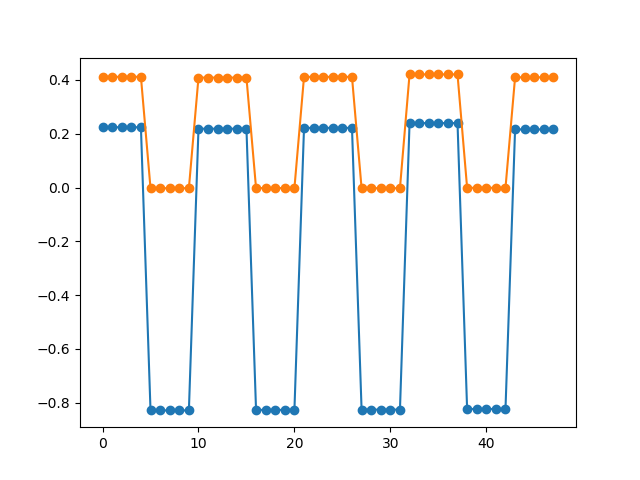

In [41]:
r.regs.lvds_idelay_auto.write(0)
close("all")
plot(p0s, "-o")
plot(p1s, "-o")

In [ ]:
r.close()